第1题解题过程：

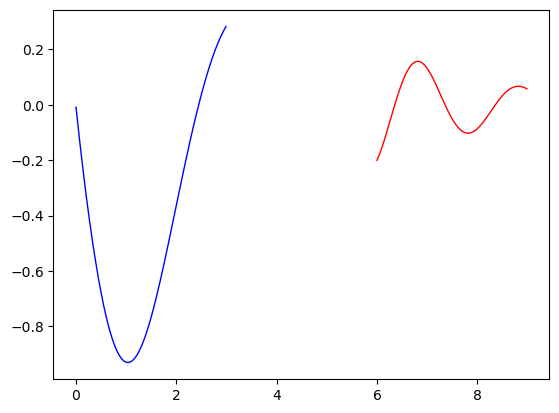

In [1]:
import numpy as np
import torch
from torch import nn
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import math
def derivative(t, theta): 
    dthetadt = (theta[1:] - theta[:-1]) / (t[1:] - t[:-1]) 
    return dthetadt 
 
def load_data(csv_path): 
    ttheta = pd.read_csv(csv_path) 
    t = np.array(ttheta["timestamp"]) 
    theta = np.array(ttheta["theta"]) 
    return t, theta 
 
def split_data(t, theta, threshold=1): 
    theta_1 = [] 
    t_1 = [] 
    theta_2 = [] 
    t_2 = [] 
    force_flag = False 
     
    t_1.append(t[0]) 
    theta_1.append(theta[0]) 
    for i in range(1, len(t)): 
        if t[i] - t[i - 1] < threshold:  #断了 
            if not force_flag: 
                t_1.append(t[i]) 
                theta_1.append(theta[i]) 
            else: 
                t_2.append(t[i]) 
                theta_2.append(theta[i]) 
        else: 
            force_flag = True 
            t_2.append(t[i]) 
            theta_2.append(theta[i]) 
     
    return np.array(t_1), np.array(theta_1), np.array(t_2), np.array(theta_2) 
 
def plot1d_data(t_1, theta_1, t_2, theta_2, img_path): 
    fig = plt.figure() 
     
    ax = fig.add_subplot() 
    ax.plot(t_1, theta_1, lw=1, color = 'blue') 
    ax.plot(t_2, theta_2, lw=1, color = 'red') 
 
    plt.savefig(img_path, bbox_inches="tight") 
    plt.show() 
    plt.cla() 
    plt.close("all") 
 
csv_path = "pendulum.csv" 
t, theta = load_data(csv_path) 
t_1, theta_1, t_2, theta_2 = split_data(t, theta) 
omega_1 = derivative(t_1, theta_1) 
omega_2 = derivative(t_2, theta_2) 
plot1d_data(t_1[:-1], omega_1, t_2[:-1], omega_2, "omega_data.png")

第2题解题过程：

In [2]:
def theta_func(thetaomega, t, alpha, beta):
    theta, omega = thetaomega
    a = - alpha * omega - beta * math.sin(theta)

    return np.array([omega, a])

class SinglePendulum(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.randn((1,), requires_grad=True))
        self.beta_1 = nn.Parameter(torch.randn((1,), requires_grad=True))
        self.beta_2 = nn.Parameter(torch.randn((1,), requires_grad=True))

    def forward(self, theta, omega, add_force=False):
        if not add_force:
            a = - self.alpha * omega - self.beta_1 * torch.sin(theta)
        else:
            a = - self.alpha * omega - self.beta_2 * torch.sin(theta)
        
        return a

a_1 = torch.from_numpy(derivative(t_1[:-1], omega_1))
#print("a1=",a_1)
a_2 = torch.from_numpy(derivative(t_2[:-1], omega_2))
#print("a2=",a_2)
_omega_1, _omega_2 = torch.from_numpy(omega_1[:-1]), torch.from_numpy(omega_2[:-1])
_theta_1, _theta_2 = torch.from_numpy(theta_1[:-2]), torch.from_numpy(theta_2[:-2])

num_epoch = 20000
model = SinglePendulum()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(num_epoch):
    optimizer.zero_grad()
    loss = torch.mean((a_1 - model(_theta_1, _omega_1, add_force=False)) ** 2)
    loss += torch.mean((a_2 - model(_theta_2, _omega_2, add_force=True)) ** 2)
    #if (i + 1) % 1000 == 0:
        #print("{}:{}".format(i + 1, loss.item()))
    loss.backward()
    optimizer.step()

alpha = (model.alpha).detach().item()
beta_1 = (model.beta_1).detach().item()
beta_2 = (model.beta_2).detach().item()
#print("alpha:{}".format(alpha))
#print("beta_1:{}".format(beta_1))
#print("beta_2:{}".format(beta_2))

print("第6s时小球的摆角为:",odeint(theta_func, [theta_1[-1], omega_1[-1]], [0, 6. - t_1[-1]], args=(alpha, beta_1))[1, 0])

第6s时小球的摆角为: 0.02199176265791564


第3题解题过程如下：

In [3]:
def get_next_zerotheta_timestamp(t, theta): 
    timestamp = 0 
    for i in range(1, len(theta)): 
        if theta[i - 1] * theta[i] < 0: 
            timestamp = t[i] 
            break 
    return timestamp 
 
sample_freq = 1000 
t = np.linspace(t_2[-1], t_2[-1] + 3, int(sample_freq * 3) + 1) 
pred_theta = odeint(theta_func, [theta_2[-1], omega_2[-1]], t - 3, args=(alpha, beta_2))[:, 0] 
 
print("下一次摆角为零的时刻为:",get_next_zerotheta_timestamp(t, pred_theta))

下一次摆角为零的时刻为: 9.916


第4题解题过程：

In [4]:
g = 9.8
m=1
l = g/beta_1
miu = alpha * m
F = (beta_2-beta_1)*m*l
print("l=", l )
print("miu = ", miu)
print("F=", F)


l= 4.909611031717939
miu =  0.8678246736526489
F= 39.038478598153546


第5题解题过程：

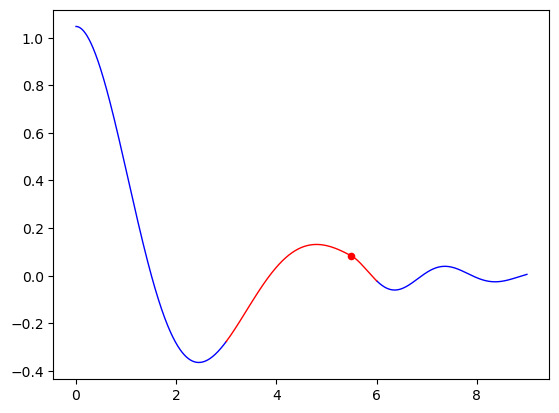

In [5]:
def neg_theta_func(thetaomega, t, alpha, beta): 
    return - theta_func(thetaomega, t, alpha, beta) 
 
def get_break_timestamp(break_t, theta_1_forward, theta_2_backward): 
    min_val = math.inf 
    min_idx = 0 
    for i in range(len(break_t) - 1): 
        val = abs(theta_1_forward[i] - theta_2_backward[i]) 
        dtheta_1 = theta_1_forward[i + 1] - theta_1_forward[i] 
        dtheta_2 = theta_2_backward[i + 1] - theta_2_backward[i] 
        val += abs((dtheta_1 - dtheta_2) / (break_t[i + 1] - break_t[i])) 
        if val < min_val: 
            min_val = val 
            min_idx = i 
     
    return break_t[min_idx] 
 
def plot1d_full_data(t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp, img_path): 
    fig = plt.figure() 
     
    ax = fig.add_subplot() 
    ax.plot(t_1, theta_1, lw=1, color = 'blue') 
    ax.plot(t_2, theta_2, lw=1, color='blue') 
    ax.plot(break_t, theta_break, lw=1, color='red') 
    ax.scatter([break_timestamp], [theta_break[break_t == break_timestamp]], s = 20, color='red') 
 
    plt.savefig(img_path, bbox_inches="tight") 
    plt.show() 
    plt.cla() 
    plt.close("all") 
 
break_t = np.linspace(t_1[-1], t_2[0], int(sample_freq * (t_2[0] - t_1[-1]))  + 1) 
theta_1_forward = odeint(theta_func, [theta_1[-1], omega_1[-1]], break_t, args=(alpha, beta_1))[:, 0] 
theta_2_backward = odeint(neg_theta_func, [theta_2[0], omega_2[0]], break_t, args=(alpha, beta_2))[::-1, 0] 
break_timestamp = get_break_timestamp(break_t, theta_1_forward, theta_2_backward) 
theta_break = np.concatenate([theta_1_forward[break_t <= break_timestamp], theta_2_backward[break_t > break_timestamp]]) 
plot1d_full_data(t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp, img_path="theta_full_data.png")
